# 심전도 데이터셋을 활용한 시계열 Anomaly Detection

환자의 빠른 응급처치와 심전도 데이터셋에서 이상 징후를 판단하는 것은 무엇보다도 중요한 일이다. 머신러닝 엔지니어 K씨는 수집된 환자의 심전도 데이터셋으로 부터 시계열 이상탐지 알고리즘을 구축하고자 한다.

데이터셋은 [ECG HeartBeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat) 을 사용하며, training data (normal data) 와 test data (abnormal data) 로 구성되어 있다.

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# home dir
%cd /content/drive/Othercomputers/내 컴퓨터/시계열/실습3/

/content/drive/Othercomputers/내 컴퓨터/시계열/실습3


In [4]:
import os
os.listdir()

['result.json', 'data', '시계열_이상탐지_실습.ipynb']

## 데이터 전처리 및 미리 보기

원본 데이터에는 3000명의 정상에 속하는 ECG 데이터가 학습 데이터로 제공되고, 2000명의 정상과 비정상이 섞여있는 데이터가 평가 데이터로 제공된다.
각 ECG 신호의 길이는 187 steps로 구성되어 있다. 우선, 제공된 train_csv, test.csv 파일을 열어보자.

In [5]:
def load_data(data_dir):
    with open(os.path.join(data_dir, "train.csv"), 'rb') as f:
        train_df = pd.read_csv(f)
    with open(os.path.join(data_dir, "test.csv"), 'rb') as f:
        test_df = pd.read_csv(f)
    return train_df, test_df

data_dir = './data/'
train_df, test_df = load_data(data_dir)

In [6]:
train_df

,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,...,t+178,t+179,t+180,t+181,t+182,t+183,t+184,t+185,t+186,anomaly
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.909884,0.290116,0.000000,0.009884,0.105233,0.180814,0.201163,0.205814,0.213372,0.229651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,1.000000,0.875617,0.140099,0.052986,0.045352,0.038617,0.091603,0.100135,0.105074,0.107319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.978657,0.646510,0.092930,0.000445,0.000445,0.040462,0.100934,0.124944,0.124944,0.129391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.934285,0.478442,0.234315,0.122212,0.113292,0.068391,0.057687,0.054416,0.045198,0.045198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 데이터 분석

정상적인 환자의 ECG 시그널의 변동성을 측정하고자 한다. 변동성은 ECG시그널의 차분 (Differencing)을 통해 구하고자 한다.
구체적으로, $t$ 시점에서 $p$번째 환자의 ECG 시그널 값을 $E_{t,p}$ 라고 할 때, $t$ 시점의 변화량 $D_{t,p}$ 는 $|E_{t,p}-E_{t-1, p}|$로 정의한다. 그리고 특정 환자에 대해 ECG 시그널의 변동성을 측정할 때, 모든 시점에서의 변화량를 합한 것을 총 변화량 ($K_p$) 으로 정의하고자 한다. 최종적으로, 환자 $p$의 ECG 시그널의 총 변화량은 $K_p = \sum_{t=1}^{T=186}D_{t,p}$ 로 정의한다.

In [7]:
data = train_df.drop("anomaly", axis=1).to_numpy()
data_shift = data[:, 1:]
diff = (data_shift - data[:, :-1])
D = np.abs(data_shift - data[:, :-1])
K = np.sum(D, axis=-1)
K

array([4.37439221, 4.91465685, 4.18466778, ..., 4.09826592, 3.89354743,
       3.73455591])

In [8]:
print(max(K))
print(min(K))

10.033576669171453
1.4744317382574077


In [9]:
print(np.mean(K))

4.469134143158755


In [10]:
data = test_df.drop("anomaly", axis=1).to_numpy()
data_shift = data[:, 1:]
D = np.abs(data_shift - data[:, :-1])
K = np.sum(D, axis=-1)
K

array([4.24501326, 4.05862571, 5.17799607, ..., 6.04433501, 5.73577693,
       6.06899925])

In [11]:
print(max(K))
print(min(K))
print(np.mean(K))

14.786666595377028
1.0838699340820312
4.700868640700093


In [12]:
# test_df에서, abnormal sample들과 normal sample들을 각각 따로 빼서, max, min, mean 찍어보기
abnormal_test_df = test_df[test_df["anomaly"] == 1]
normal_test_df = test_df[test_df["anomaly"] == 0]

In [13]:
print(len(abnormal_test_df))
print(len(normal_test_df))

1000
1000


In [14]:
data = abnormal_test_df.drop("anomaly", axis=1).to_numpy()
data_shift = data[:, 1:]
diff = (data_shift - data[:, :-1])
D = np.abs(data_shift - data[:, :-1])
K = np.sum(D, axis=-1)
K

print(max(K))
print(min(K))
print(np.mean(K))

14.786666595377028
2.1826279088854794
4.921425382409303


In [15]:
data = normal_test_df.drop("anomaly", axis=1).to_numpy()
data_shift = data[:, 1:]
diff = (data_shift - data[:, :-1])
D = np.abs(data_shift - data[:, :-1])
K = np.sum(D, axis=-1)
K

print(max(K))
print(min(K))
print(np.mean(K))

7.662559717893601
1.0838699340820312
4.480311898990884



### 데이터 시각화

병원 측에서 ECG 데이터의 동향을 파악하기 위한 분석을 요청해왔다.
병원 측의 요구사항은, 정상 환자의 평균적인 동향과 분포를 함께 보고싶다는 것이다.

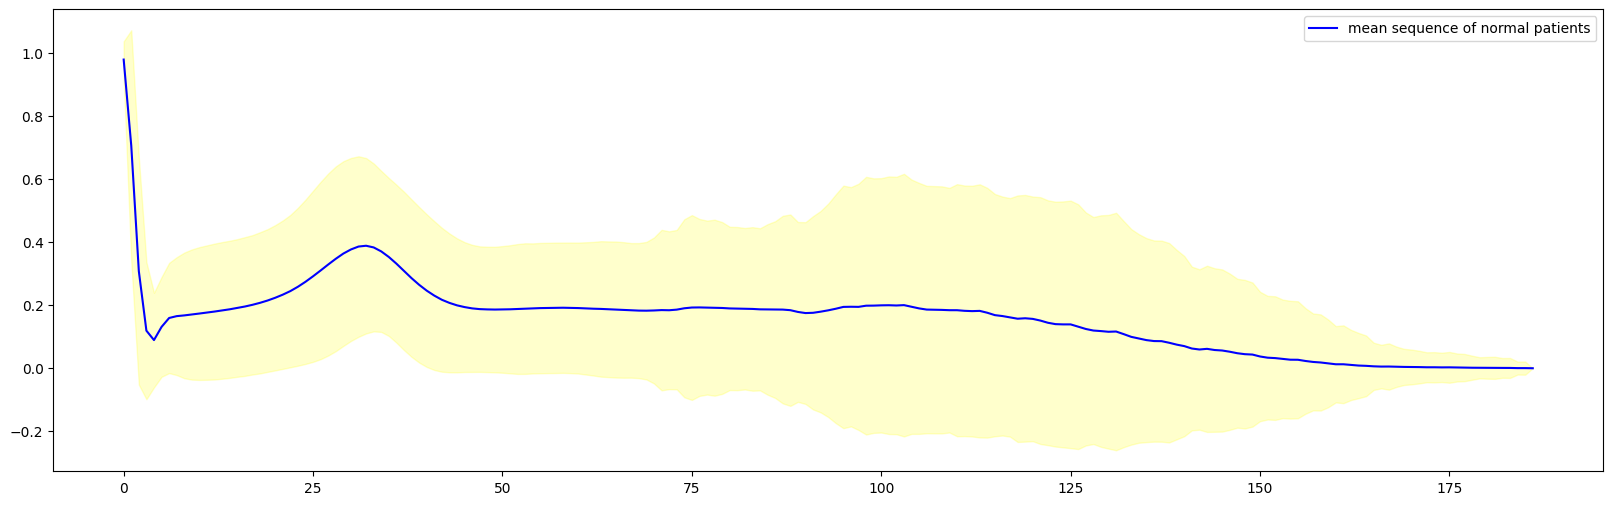

In [16]:
data = train_df.drop("anomaly", axis=1).to_numpy()
data_mu = data.mean(axis=0)
data_std = np.std(data, axis=0)
x = np.arange(0, 187)
plt.figure(figsize=(20, 6))
plt.plot(x, data_mu, color="blue", label="mean sequence of normal patients")
plt.fill_between(x, data_mu-1.96*data_std, data_mu+1.96*data_std, alpha=0.2, color="yellow")
plt.legend()
plt.show()

## 시계열 Anomaly Detection 모델 학습

이제, AutoEncoder 구조를 활용하여 시계열 이상탐지 작업을 수행하고자 한다.



### PyTorch 데이터셋 클래스 정의

In [17]:
train_X, train_y = train_df.drop("anomaly", axis=1).to_numpy(), train_df["anomaly"].astype(int)
train_X.shape, train_y.shape

((3000, 187), (3000,))

In [18]:
test_X, test_y = test_df.drop("anomaly", axis=1).to_numpy(), test_df["anomaly"].astype(int)
test_X.shape, test_y.shape

((2000, 187), (2000,))

In [19]:
class ECG(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X, self.y = X, y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self,
                    idx: int) -> np.ndarray:
        return self.X[idx], self.y[idx]


_train_data = ECG(train_X, train_y)
_test_data = ECG(test_X, test_y)

In [20]:
sX, sy = _train_data[31]
sX.shape, sy.shape

((187,), ())

In [21]:
print(sX)
print(sy)

[1.         0.93806541 0.5212248  0.13709116 0.         0.21572721
 0.33681279 0.34725121 0.37160751 0.39248434 0.39178845 0.40292275
 0.39874738 0.40013918 0.40501043 0.42032012 0.4335421  0.44119695
 0.45233124 0.46694502 0.47251219 0.49060541 0.52609605 0.54766876
 0.58733475 0.6360473  0.6784969  0.72581768 0.76339597 0.79540712
 0.81210858 0.82254696 0.80375785 0.74321502 0.66805845 0.58385527
 0.50661099 0.43910927 0.41544884 0.38970077 0.36951983 0.3611691
 0.35699373 0.35560194 0.34725121 0.34585944 0.33681279 0.3270703
 0.33194155 0.33054975 0.33194155 0.33681279 0.33681279 0.34168407
 0.34725121 0.34446764 0.34933889 0.34933889 0.35281837 0.35073069
 0.34377176 0.34933889 0.34585944 0.34585944 0.34794712 0.348643
 0.34446764 0.34029227 0.33611691 0.33194155 0.32776618 0.34725121
 0.38900489 0.41962421 0.43075854 0.44537231 0.49895614 0.49895614
 0.52331245 0.51287407 0.46624914 0.40988171 0.33611691 0.3145442
 0.30062631 0.30340987 0.29993042 0.2901879  0.29784274 0.2901879
 

### 모델 구현


위에서 구현한 데이터셋을 활용해 **심전도 데이터셋을 입력으로 넣었을 때, 이를 reconstruction 하는 방식으로 학습하는 AutoEncoder 구조의 모델**을 학습하고자 한다. 위

모델은 *(batch, input_length)* 의 시계열 데이터를 입력받아 *(batch, input_length)* 의 심전도 데이터를 reconstruction한다.

In [ ]:
random.seed(59683)
torch.manual_seed(59683)
np.random.seed(59683)

class Encoder(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, input_size // 2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(input_size // 2, input_size // 4)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(input_size // 4, latent_space_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        out = self.relu3(x)
        return out

class Decoder(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_space_size, input_size // 4)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(input_size // 4, input_size // 2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(input_size // 2, input_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        out = self.sigmoid(x)
        return out

# LSTM AutoEncoder



## AutoEncoder
# class MyModel(nn.Module):
#     def __init__(self, input_size, latent_space_size):
#         super().__init__()
#         self.encoder = Encoder(input_size, latent_space_size)
#         self.decoder = Decoder(input_size, latent_space_size)

#     def forward(self, x):
#         z = self.encoder(x)
#         out = self.decoder(z)
#         return out

# # USAD
# class MyModel(nn.Module):
#     def __init__(self, input_size, latent_space_size):
#         super().__init__()
#         self.encoder = Encoder(input_size, latent_space_size)
#         self.decoder_1 = Decoder(input_size, latent_space_size)
#         self.decoder_2 = Decoder(input_size, latent_space_size)

#     def forward(self, x):
#         z = self.encoder(x)
#         out_1 = self.decoder_1(z)
#         out_2 = self.decoder_2(z)
#         out_3 = self.decoder_2(self.encoder(out_1))
#         return out_1, out_2, out_3

In [ ]:
# debug_encoder = Encoder(input_size=300, latent_space_size=30)
# sample_input = torch.randn(96, 300)
# assert debug_encoder(sample_input).shape == (96, 30)

# debug_decoder = Decoder(input_size=300, latent_space_size=30)
# sample_input = torch.randn(96, 30)
# assert debug_decoder(sample_input).shape == (96, 300)

### 모델 학습 코드 구현

이제 모델 학습을 진행하고자 한다.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
random.seed(15473)
torch.manual_seed(15473)
np.random.seed(15473)

INPUT_DIM = 187
BATCH_SIZE = 64
LATENT_DIM = 32
EPOCHS = 100
learning_rate = 1e-03
train_dataset = ECG(train_X, train_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

epoch_iterator = tqdm(
    range(EPOCHS),
    desc="training",
    leave=True
)

## AutoEncoder
# model = MyModel(input_size=INPUT_DIM, latent_space_size=LATENT_DIM).to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


# for epoch in epoch_iterator:
#     train_loss = 0

#     for i, batch_data in enumerate(train_loader):
#         X = batch_data[0].float().to(device)
#         B, L = X.shape
#         Xhat = model(X)

#         optimizer.zero_grad()
#         loss = F.mse_loss(Xhat, X)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#     train_loss /= len(train_loader)

#     epoch_iterator.set_postfix({f"train_loss":train_loss})


## USAD
# model = MyModel(input_size=INPUT_DIM, latent_space_size=LATENT_DIM).to(device)
# optimizer_1 = torch.optim.Adam(params=list(model.encoder.parameters())+list(model.decoder_1.parameters()), lr=learning_rate)
# optimizer_2 = torch.optim.Adam(params=list(model.encoder.parameters())+list(model.decoder_2.parameters()), lr=learning_rate)

# for epoch in epoch_iterator:
#     train_loss_1 = 0
#     train_loss_2 = 0

#     model.train()
#     for i, batch_data in enumerate(train_loader):
#         X = batch_data[0].float().to(device)
#         B, L = X.shape
#         Xhat_1, Xhat_2, Xhat_3 = model(X)

#         optimizer_1.zero_grad()
#         optimizer_2.zero_grad()

#         loss1 = (1 / (epoch+1)) * F.mse_loss(Xhat_1, X) + (1 - 1 / (epoch+1)) * F.mse_loss(Xhat_3, X)
#         loss2 = (1 / (epoch+1)) * F.mse_loss(Xhat_2, X) - (1 - 1 / (epoch+1)) * F.mse_loss(Xhat_3, X)

#         loss1.backward(retain_graph=True)
#         loss2.backward(retain_graph=True)

#         optimizer_1.step()
#         optimizer_2.step()

#         train_loss_1 += loss1.item()
#         train_loss_2 += loss2.item()
#     train_loss_1 /= len(train_loader)
#     train_loss_2 /= len(train_loader)

#     epoch_iterator.set_postfix({f"train_loss_1": train_loss_1, f"train_loss_2": train_loss_2})

training: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, train_loss=0.00242]


### Reconstruction error로부터 anomaly score 얻기

ECG data의 anomaly score를 model reconstruction error의 평균으로 정의하자.

In [ ]:
# AutoEncoder
def get_anomaly_scores(model, iterator):
    model.eval()
    model.to(device)

    # get reconstruction errors
    with torch.no_grad():
        recon_errors = []

        for i, batch_data in enumerate(iterator):
            X = batch_data[0].float().to(device)
            B, L = X.shape
            Xhat = model(X)

            recon_error = F.mse_loss(Xhat, X, reduction="none").mean(dim=1)
            recon_errors.append(recon_error)

        recon_errors = torch.cat(recon_errors, dim=0).cpu().numpy()

    anomaly_scores = recon_errors
    return anomaly_scores

train_iterator = tqdm(
    train_loader,
    desc="getting training recon loss",
    leave=True
)
train_anomaly_scores = get_anomaly_scores(model, train_iterator)

getting training recon loss: 100%|██████████| 47/47 [00:00<00:00, 754.22it/s]


In [ ]:
## USAD
# def get_anomaly_scores(model, iterator):
#     model.eval()
#     model.to(device)

#     # get reconstruction errors
#     with torch.no_grad():
#         recon_errors = []

#         for i, batch_data in enumerate(iterator):
#             X = batch_data[0].float().to(device)
#             B, L = X.shape
#             Xhat_1, Xhat_2, Xhat_3 = model(X)

#             recon_error_1 = F.mse_loss(Xhat_1, X, reduction="none").mean(dim=1)
#             recon_error_2 = F.mse_loss(Xhat_3, X, reduction="none").mean(dim=1)
#             recon_error = 0.5*recon_error_1 + 0.5*recon_error_2
#             recon_errors.append(recon_error)
#         recon_errors = torch.cat(recon_errors, dim=0).cpu().numpy()

#     anomaly_scores = recon_errors
#     return anomaly_scores

# train_iterator = tqdm(
#     train_loader,
#     desc="getting training recon loss",
#     leave=True
# )
# train_anomaly_scores = get_anomaly_scores(model, train_iterator)

### train reconstruction error로부터 threshold 얻기

이제 정상과 비정상을 구분하는 기준값인 threshold를 설정하고자 한다.

train data중, 적어도 95%의 데이터가 normal dataset이라고 가정하자.

train_data의 anomaly score중, 상위 5%에 해당하는 값을 threshold 변수에 할당한다.

In [ ]:
noise_ratio = 0.1
threshold = np.percentile(train_anomaly_scores, 100*(1-noise_ratio))

### test_data에 대해 구해진 threshold로 inference 진행하기

Test data에 대하여 reconstruction error를 구한 뒤, threshold를 활용하여 예측을 진행하시오.

In [ ]:
test_dataset = ECG(test_X, test_y)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_iterator = tqdm(
    test_loader,
    desc="getting testing recon loss",
    leave=True
)
test_anomaly_scores = get_anomaly_scores(model, test_iterator)
test_y_pred = test_anomaly_scores > threshold

p = np.round(precision_score(test_y, test_y_pred), 3)
r = np.round(recall_score(test_y, test_y_pred), 3)
acc = np.round(accuracy_score(test_y, test_y_pred), 3)
f1 = np.round(f1_score(test_y, test_y_pred), 3)

getting testing recon loss: 100%|██████████| 32/32 [00:00<00:00, 663.98it/s]


In [ ]:
print('{} : {}'.format('precision', p))
print('{} : {}'.format('recall', r))
print('{} : {}'.format('accuracy', acc))
print('{} : {}'.format('f1', f1))

precision : 0.797
recall : 0.58
accuracy : 0.716
f1 : 0.671


### 결과 시각화

마지막으로 예측 결과를 시각화하고자 한다.

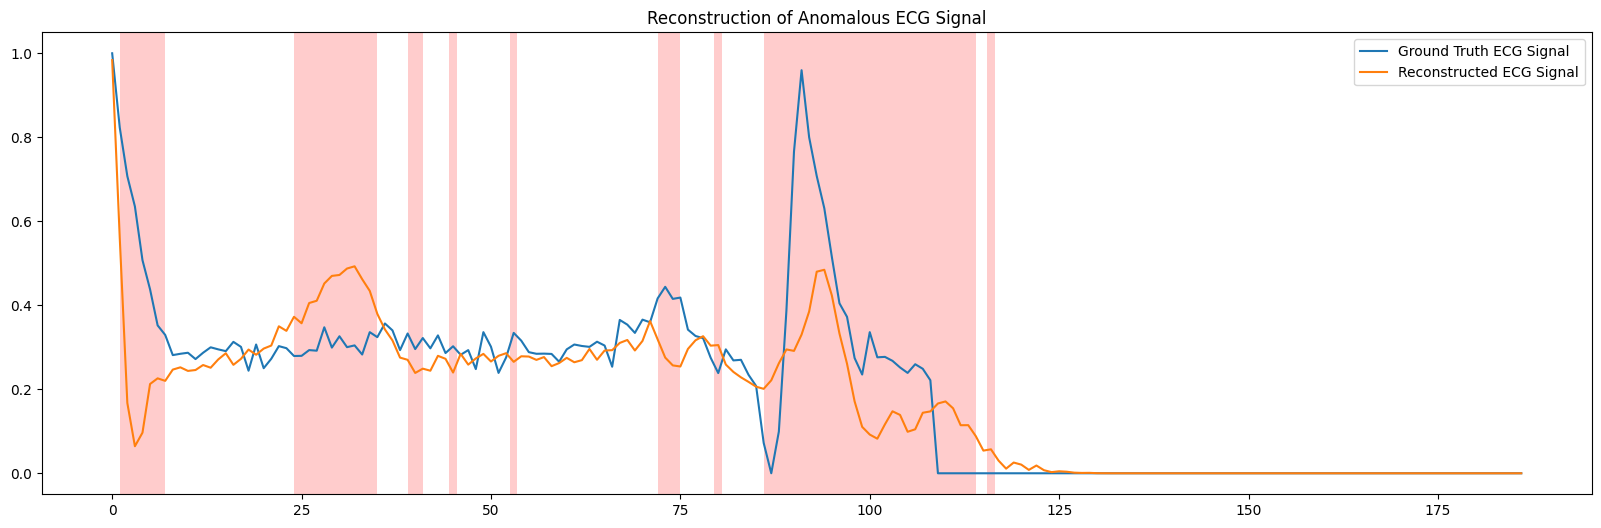

In [ ]:
 # 이상 구간의 기준
anomalous_interval_threshold = 0.003

# 모델이 이상 탐지를 성공한 구간을 하나 고름
sample_anomaly_idx = np.where((test_y==1) & (test_y_pred == 1))[0][0]
sample_anomaly = torch.tensor(test_X[sample_anomaly_idx]).float().to(device)

# reconstruction을 수행함
with torch.no_grad():
    model.eval()
    sample_anomaly_recon, _, _ = model(sample_anomaly)

sample_mse = F.mse_loss(sample_anomaly_recon, sample_anomaly, reduction="none")
above_threshold = sample_mse > anomalous_interval_threshold

plt.figure(figsize=(20, 6))
plt.title("Reconstruction of Anomalous ECG Signal")

plt.plot(sample_anomaly.cpu().numpy(), label="Ground Truth ECG Signal")
plt.plot(sample_anomaly_recon.cpu().numpy(), label="Reconstructed ECG Signal")

s, e = None, None
for i, v in enumerate(above_threshold):
    if v == True and s is None:
        s = i
    elif v == False and s is not None:
        e = i - 1
        if (e - s) > 0:
            plt.axvspan(s, e, facecolor='red', alpha=0.2)
        else:
            plt.axvspan(s-0.5, s+0.5, facecolor='red', alpha=0.2)
        s, e = None, None

plt.legend()
plt.show()